## CSE 676 Deep Learning Final Project
## Model-3: Image Captioning with Xception + Transformer

Srikar Challa, 50312357 (srikarch@buffalo.edu) <br>
Srisai Karthik Neelamraju, 50316785 (neelamra@buffalo.edu) <br>
Anantha Srinath Sedimbi, 50315869 (asedimbi@buffalo.edu)

### Importing the required libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import xception, Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.nn import relu, softmax, tanh
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pickle
import nltk
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Loading the Flickr 8K dataset

In [0]:
try:
    captions = pickle.load(open("/content/gdrive/My Drive/flickr8k_checkpoints/captions.p", "rb"))
    captions_dict = pickle.load(open("/content/gdrive/My Drive/flickr8k_checkpoints/captions_dict.p", "rb"))
    image_names = pickle.load(open("/content/gdrive/My Drive/flickr8k_checkpoints/image_names.p", "rb"))
except:
    images_path = '/content/gdrive/My Drive/flickr8k/flickr8k-images/'
    captions_path = '/content/gdrive/My Drive/flickr8k/flickr8k-captions.txt'
    captions_file = open(captions_path, 'r')
    captions = []
    captions_dict = {}
    image_names = []
    for line in captions_file:
        spl = line.split('\t')
        img_name = images_path + spl[0].split('#')[0]
        caption = '<start> ' + spl[1].split('.')[0].strip() + ' <end>'
        captions.append(caption)
        image_names.append(img_name)
        if img_name in captions_dict:
            captions_dict[img_name].append(spl[1].split('.')[0].strip().split(' '))
        else:
            captions_dict[img_name] = [spl[1].split('.')[0].strip().split(' ')]
    pickle.dump(captions, open("/content/gdrive/My Drive/flickr8k_checkpoints/captions.p", "wb"))
    pickle.dump(captions_dict, open("/content/gdrive/My Drive/flickr8k_checkpoints/captions_dict.p", "wb"))
    pickle.dump(image_names, open("/content/gdrive/My Drive/flickr8k_checkpoints/image_names.p", "wb"))

### Preprocessing the images in the dataset

In [0]:
def preprocess(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = xception.preprocess_input(img)
    return img, image_path

# defining pre-trained Xception model
Xception_ = Xception(include_top=False, weights='imagenet')
xception_model = Model(Xception_.input, Xception_.output)

# # extracting image features from Xception network
# # features are written to disk
# img_names = list(captions_dict.keys())
# image_dataset = tf.data.Dataset.from_tensor_slices(img_names)
# image_dataset = image_dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)
# for img, path in image_dataset:
#     batch_features = xception_model(img)
#     batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
#     for bf, p in zip(batch_features, path):
#         path_of_feature = p.numpy().decode('utf-8')
#         np.save(path_of_feature, bf.numpy())

### Tokenizing the captions and splitting the dataset

In [0]:
tokenizer = Tokenizer(num_words=5000, oov_token='<unk>', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
sequences = tokenizer.texts_to_sequences(captions)
max_len = max(len(seq) for seq in sequences)
captions_padded = pad_sequences(sequences, padding='post', maxlen=max_len)

# splitting the dataset
img_names_train, img_names_test, captions_train, captions_test = train_test_split(image_names, captions_padded, test_size=0.2, random_state=0)

### Defining the hyperparameters for training the network

In [0]:
batch_size = 64
num_layers = 2
d_model = 128
buffer_size = 1000
dff = 256
num_heads = 4
target_vocab_size = 5001
input_vocab_size = target_vocab_size
dropout_rate = 0
n_iter = len(img_names_train) // batch_size

### Defining Positional Encoding and Masking Helper Functions

In [0]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  
    pos_encoding = angle_rads[np.newaxis, ...] 
    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, combined_mask, dec_padding_mask

### Defining Multi-Head Attention Layer

In [0]:
# scaled dot product attention
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)  
    return output, attention_weights

# Multi-Head Attention Model
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        return output, attention_weights

# point-wise feed forward neural network
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

### Defining the Transformer encoder and decoder layers (individual)

In [0]:
# Single Encoder Layer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

# Single Decoder Layer
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)   
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)    
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        return out3, attn_weights_block1, attn_weights_block2

### Defining the Transformer encoder and decoder

In [0]:
# Transformer Encoder
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.fc1 = Dense(d_model)
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,self.d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]      
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.fc1(x)
        x = relu(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)  
        return x

# Transformer Decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        return x, attention_weights

### Defining the Transformer model

In [0]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)    
        final_output = self.final_layer(dec_output)
        return final_output, attention_weights

transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input=input_vocab_size, pe_target=target_vocab_size, rate=dropout_rate)

### Creating a TensorFlow dataset object of the training set

In [0]:
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_names_train, captions_train))
dataset = dataset.map(lambda x1, x2: tf.numpy_function(map_func, [x1, x2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Defining the loss function

In [0]:
# using Adam Optimizer for the network
optimizer = Adam()
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# custom-loss function
def custom_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    return tf.reduce_mean(loss_ * mask)

### Creating a checkpoint manager for saving the network weights

In [13]:
chkpt_path = '/content/gdrive/My Drive/transformer/train'
chkpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
chkpt_manager = tf.train.CheckpointManager(chkpt, chkpt_path, max_to_keep=1)
if chkpt_manager.latest_checkpoint:
    print("Found a checkpoint")
    chkpt.restore(chkpt_manager.latest_checkpoint)

Found a checkpoint


### Training the network

In [0]:
# @tf.function
# def train_step(inp, tar):
#     loss = 0
#     tar_inp = tar[:, :-1]
#     tar_real = tar[:, 1:]
#     _, combined_mask, _ = create_masks(inp, tar_inp)  
#     with tf.GradientTape() as tape:
#         predictions, _ = transformer(inp, tar_inp, True, None, combined_mask, None)
#         loss += custom_loss(tar_real, predictions)
#         gradients = tape.gradient(loss, transformer.trainable_variables)    
#         optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
#     return loss

In [0]:
# try:
#     train_losses = pickle.load(open("/content/gdrive/My Drive/transformer/losses.p", "rb"))
# except:
#     train_losses = []
# 
# epochs = 1
# start = len(train_losses) + 1
# for ep in range(start, start+epochs):
#     total_loss = 0
#     for (batch, (img_tensor, target)) in enumerate(dataset):
#         batch_loss = train_step(img_tensor, target)
#         total_loss += batch_loss
#         if batch % 1 == 0:
#             print('Epoch: ' + str(ep) + '\tBatch: ' + str(batch) + '\tLoss: ' + str(batch_loss.numpy()))
#             break
#     train_losses.append(total_loss/n_iter)
#     if ep % 5 == 0 or ep == start + epochs - 1:
#         pickle.dump(train_losses, open("/content/gdrive/My Drive/transformer/losses.p", "wb"))
#         chkpt_manager.save()
#     print('Epoch: ' + str(ep) + '\tLoss: ' + str(total_loss.numpy()/n_iter))

### Making prediction on a testing set image

In [0]:
def evaluate(image):
  temp_input = tf.expand_dims(preprocess(image)[0], 0)
  img_tensor_val = xception_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
  result = []
  for i in range(max_len):
      _, combined_mask, _ = create_masks(img_tensor_val, dec_input)
      predictions, attention_weights = transformer(img_tensor_val, dec_input, False, None, combined_mask, None)      
      predictions = predictions[: ,-1:, :]
      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      pred_id_int = predicted_id.numpy()[0][0]
      result.append(tokenizer.index_word[pred_id_int])
      if tokenizer.index_word[pred_id_int] == '<end>':
              return result
      dec_input = tf.concat([dec_input, predicted_id], axis=-1)
  return result

Original Image


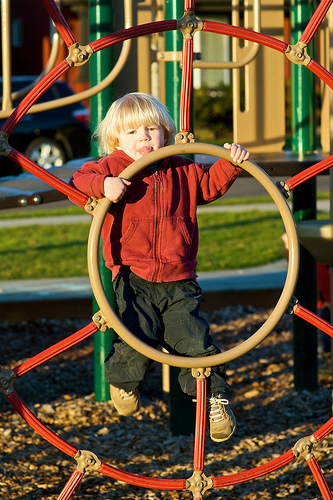

Real Captions:
1. A child in a red child plays on playground equipment
2. A little kid plays on the equipment at the park
3. A small blond child wearing a red jacket climbs on a playground
4. Blond child wearing a red jacket and crawling on playground equipment
5. The kid at the playground has a red sweater on
Predicted Caption:
a kid plays on harnesses wearing a red shirt


In [17]:
# randomly selecting a testing set image and predicting its caption
test_img = img_names_test[np.random.choice(len(img_names_test))]
pred_caption = evaluate(test_img)

# viewing the original image
print("Original Image")
cv2_imshow(cv2.imread(test_img))

# real captions of the image
print("Real Captions:")
real_captions = [' '.join(captions_dict[test_img][i]) for i in range(5)]
for i in range(5):
    print(str(i+1) + ". " + real_captions[i])

# caption of the image predicted by our model
print("Predicted Caption:")
print(' '.join(pred_caption[0:-1]))

### Computing BLEU scores on the testing set

In [18]:
# PREDICTIONS: finding the predicted captions for all test set images
# type list(list(str))
print("Finding the predictions on the testing set ...", end=' ')
try:
    pred_captions = pickle.load(open("/content/gdrive/My Drive/transformer/pred_captions.p", "rb"))
except:
    pred_captions = []
    i = 0
    for img in img_names_test:
        i += 1
        if i % 50 == 0:
            pickle.dump(pred_captions, open("/content/gdrive/My Drive/transformer/pred_captions.p", "wb"))
        pred_caption = evaluate(img)
        pred_captions.append(pred_caption[1:-1])
print("DONE")

# REFERENCES: aggregating all 5 original captions for all test set images
# type list(list(list(str)))
try:
    ref_list = pickle.load(open("/content/gdrive/My Drive/transformer/ref_list.p", "rb"))
except:
    ref_list = []
    for img in img_names_test:
        ref_list.append(captions_dict[img])
    pickle.dump(pred_captions, open("/content/gdrive/My Drive/transformer/ref_list.p", "wb"))

# BLEU SCORES: computes BLEU-1, BLEU-2, BLEU-3 and BLEU-4 scores
print("Computing BLEU scores ...", end=' ')
bleu_1 = nltk.translate.bleu_score.corpus_bleu(ref_list, pred_captions, weights=(1, 0, 0, 0))
bleu_2 = nltk.translate.bleu_score.corpus_bleu(ref_list, pred_captions, weights=(0, 1, 0, 0))
bleu_3 = nltk.translate.bleu_score.corpus_bleu(ref_list, pred_captions, weights=(0, 0, 1, 0))
bleu_4 = nltk.translate.bleu_score.corpus_bleu(ref_list, pred_captions, weights=(0, 0, 0, 1))
print("DONE\nBLEU-1\t", bleu_1)
print("BLEU-2\t", bleu_2)
print("BLEU-3\t", bleu_3)
print("BLEU-4\t", bleu_4)

Finding the predictions on the testing set ... DONE
Computing BLEU scores ... DONE
BLEU-1	 0.7265883769908301
BLEU-2	 0.539538878351342
BLEU-3	 0.4305103742651103
BLEU-4	 0.365167856381711


#### References

1. https://keras.io/ <br>
2. https://arxiv.org/pdf/1610.02357.pdf <br>
3. https://www.tensorflow.org/tutorials/text/image_captioning <br>
4. https://www.tensorflow.org/tutorials/text/transformer <br>
5. https://arxiv.org/pdf/1502.03044.pdf <br>
6. https://arxiv.org/pdf/1706.03762.pdf <br>
7. https://www.nltk.org/_modules/nltk/translate/bleu_score.html